In [1]:
import torch
import pandas as pd
import numpy as np
import gc
import os
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv(r'C:\Users\85842\OneDrive\文档\GitHub\shandong_AIS\list\bhw_points_2024010112_merged.csv')
df.head()

,time,mmsi,status,lon,lat,sog,cog,trueHeading,imo,name,type,length,width,yday
0,2024-01-01T12:00:00Z,800019462,NaN,122.0151,37.8412,28,2846,511,NaN,LU WEI JING YU 65751,NaN,NaN,NaN,1.0
1,2024-01-01T12:00:00Z,800019462,NaN,122.0151,37.8412,28,2846,511,NaN,NaN,30.0,16.0,4.0,1.0
2,2024-01-01T12:00:00Z,800019462,NaN,122.0151,37.8412,28,2846,511,NaN,LU WEI JING YU 65751,NaN,NaN,NaN,1.0
3,2024-01-01T12:00:00Z,800019462,NaN,122.0151,37.8412,28,2846,511,NaN,NaN,30.0,16.0,4.0,1.0
4,2024-01-01T12:00:01Z,412336814,NaN,122.0916,37.7843,38,2876,511,NaN,NaN,30.0,0.0,0.0,1.0


type 编码分布（含缺失）：
type_label  count
   missing   5543
       0.0    136
      20.0      1
      30.0   5733
      31.0      1
      36.0      1
      37.0     29
      52.0    660
      60.0      2
      69.0    189
      70.0   7044
      71.0     29
      79.0    286
      80.0     17
      90.0      1
     191.0     15
     253.0    149


C:\Users\85842\AppData\Local\Temp\ipykernel_21248\3960274885.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=type_counts, x="type_label", y="count", palette="viridis")


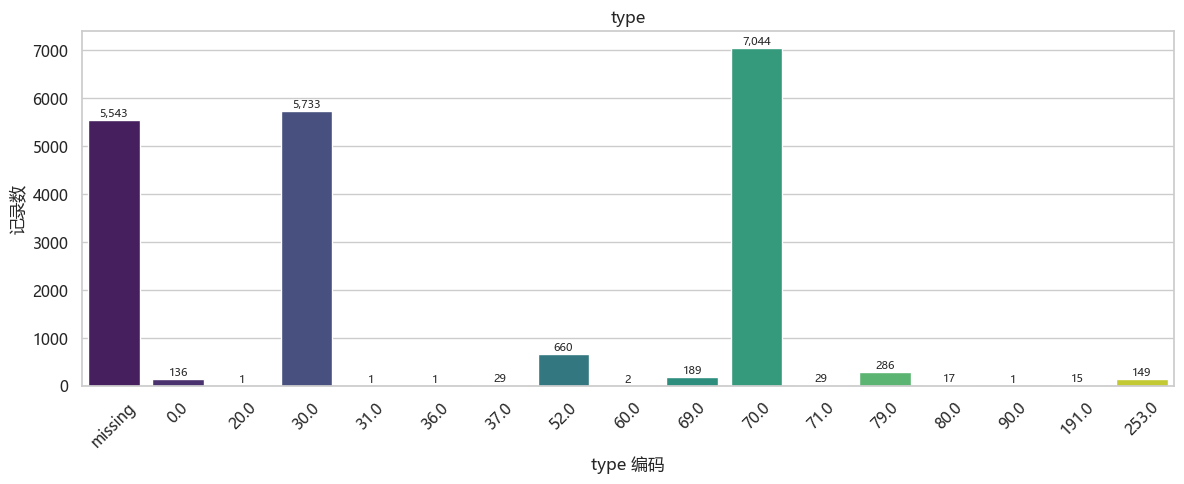

In [3]:
type_series = df['type'].astype('Int64')

type_counts = (
    type_series
    .value_counts(dropna=False)
    .rename_axis("type_code")
    .reset_index(name="count")
)

type_counts["type_label"] = type_counts["type_code"].apply(
    lambda code: "missing" if pd.isna(code) else str(code)
)
type_counts["sort_key"] = type_counts["type_code"].fillna(-1)
type_counts = type_counts.sort_values("sort_key").drop(columns="sort_key").reset_index(drop=True)

print("type 编码分布（含缺失）：")
print(type_counts[["type_label", "count"]].to_string(index=False))

sns.set_theme(style="whitegrid")
# 强制设置中文字体，避免图标题/标签乱码
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize=(12, 5))
sns.barplot(data=type_counts, x="type_label", y="count", palette="viridis")
plt.xlabel("type 编码")
plt.ylabel("记录数")
plt.title("type")
plt.xticks(rotation=45)

for tick_idx, count in enumerate(type_counts["count"]):
    plt.text(tick_idx, count, f"{int(count):,}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()

船舶分类计数（仅保留任务关注类型，其余归为“非运输船”）：
ship_category  count
         危险品船     29
           货船   7330
           油船     17
           客船    191
           渔船   5733
         非运输船    993
           未知   5543


C:\Users\85842\AppData\Local\Temp\ipykernel_21248\191969929.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


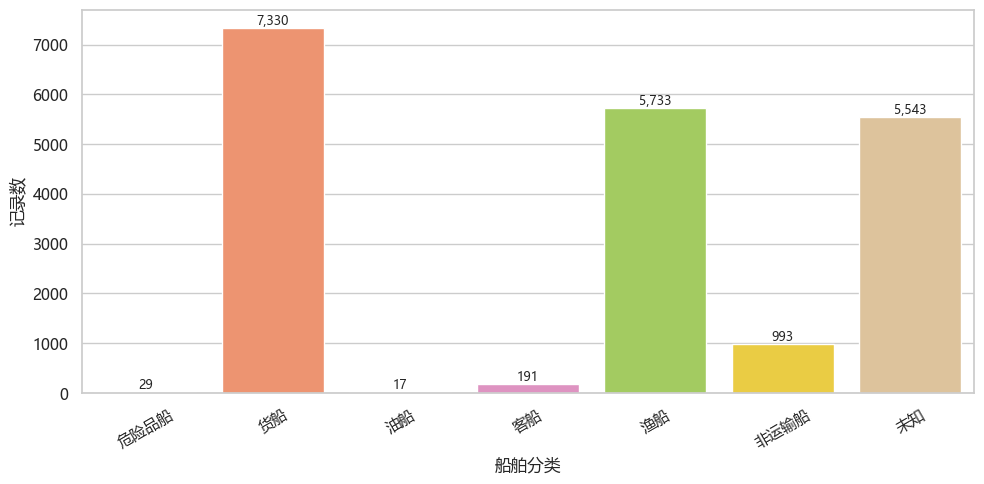

In [4]:
# 强制设置中文字体，避免图标题/标签乱码
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False

danger_codes = {71, 72, 73, 74, 81, 82, 83, 84, 91, 92, 93, 94}
cargo_codes = set(range(70, 80))
oil_codes = set(range(80, 90))
passenger_codes = set(range(60, 70))
fish_codes = {30}

ship_category_rules = [
    ("危险品船", danger_codes),
    ("货船", cargo_codes),
    ("油船", oil_codes),
    ("客船", passenger_codes),
    ("渔船", fish_codes),
]

def classify_ship_type(code):
    if pd.isna(code):
        return "未知"
    code_int = int(code)
    for label, allowed_codes in ship_category_rules:
        if code_int in allowed_codes:
            return label
    return "非运输船"

type_series = df["type"].astype("Int64")
df["ship_category"] = type_series.apply(classify_ship_type)

ship_category_order = [
    "危险品船",
    "货船",
    "油船",
    "客船",
    "渔船",
    "非运输船",
    "未知",
]
category_counts = (
    df["ship_category"]
    .value_counts()
    .reindex(ship_category_order, fill_value=0)
    .rename_axis("ship_category")
    .reset_index(name="count")
)

print("船舶分类计数（仅保留任务关注类型，其余归为“非运输船”）：")
print(category_counts.to_string(index=False))

plt.figure(figsize=(10, 5))
order = category_counts["ship_category"]
sns.barplot(
    data=category_counts,
    x="ship_category",
    y="count",
    palette="Set2",
    order=order,
    saturation=0.8,
    dodge=False,
    )
plt.xlabel("船舶分类")
plt.ylabel("记录数")

plt.xticks(rotation=30)

for idx, row in category_counts.iterrows():
    plt.text(idx, row["count"], f"{int(row['count']):,}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()

In [5]:
#2025年度交通流统计分析系统
#使用PyTorch进行张量化计算，支持CUDA加速


import os
import sys
import argparse
import yaml
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm import tqdm

class TrafficFlowAnalyzer:
    #交通流分析器
    def __init__(self, config_path:str="config.yaml"):

        self.config=self._load_config(config_path)
        self.device=self._setup_device()
        self.ais_data=None
        self.ship_info=None
    def _load_config(self, config_path:str)->Dict:
        #加载配置文件
        with open(config_path, 'r') as file:
            config=yaml.safe_load(file)
        return config
    def _setup_device(self)->torch.device:
        #设置计算设备
        if torch.cuda.is_available() and self.config.get('use_cuda', False):
            return torch.device('cuda')
        else:
            return torch.device('cpu')
    def load_data(self):
        #加载AIS数据和船舶信息
        ais_ship_data_path=self.config['data_files']['premerged_ais']
        self.ais_data=pd.read_csv(ais_ship_data_path)
        print(f"Loaded AIS data with {len(self.ais_data)} records.")
        return self.ais_data
    def ship_type_filter(self,config:Dict):
        ship_types=config.get('ship_types', [])
        return ship_types




In [6]:
sub_df=df[['mmsi','type','length']].copy()
sub_df.insert(0,'id',range(0,len(sub_df)))
def robust_judge(series):
    valid=series.dropna()

    if len(valid)==0:
        return np.nan
    counts=valid.value_counts()
    if len(counts)==1:
        return counts.index[0]
    if counts.iloc[0]>counts.iloc[1]:
        return counts.index[0]
    return np.nan
ship_df=(sub_df
         .groupby('mmsi')
         .agg({'type':robust_judge,
               'length':robust_judge}))
total_ships=len(ship_df)
type_missing = ship_df["type"].isna().sum()
length_missing = ship_df["length"].isna().sum()

type_missing_ratio = type_missing / total_ships
length_missing_ratio = length_missing / total_ships
print(f"总船舶数: {total_ships}")
print(f"type 缺失船舶数: {type_missing} ({type_missing_ratio:.2%})")
print(f"length 缺失船舶数: {length_missing} ({length_missing_ratio:.2%})")


总船舶数: 97
type 缺失船舶数: 9 (9.28%)
length 缺失船舶数: 11 (11.34%)


In [7]:
both_missing=ship_df[ship_df['type'].isna() & ship_df['length'].isna()]
both_missing_count=len(both_missing)
both_missing_ratio=both_missing_count/total_ships
print(f"type 和 length 均缺失船舶数: {both_missing_count} ({both_missing_ratio:.2%})")

type 和 length 均缺失船舶数: 9 (9.28%)


C:\Users\85842\AppData\Local\Temp\ipykernel_21248\573713129.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=ship_df, x='type', order=ship_df['type'].value_counts().index, palette='muted')


Text(0.5, 1.0, 'Ship type 分布（count）')

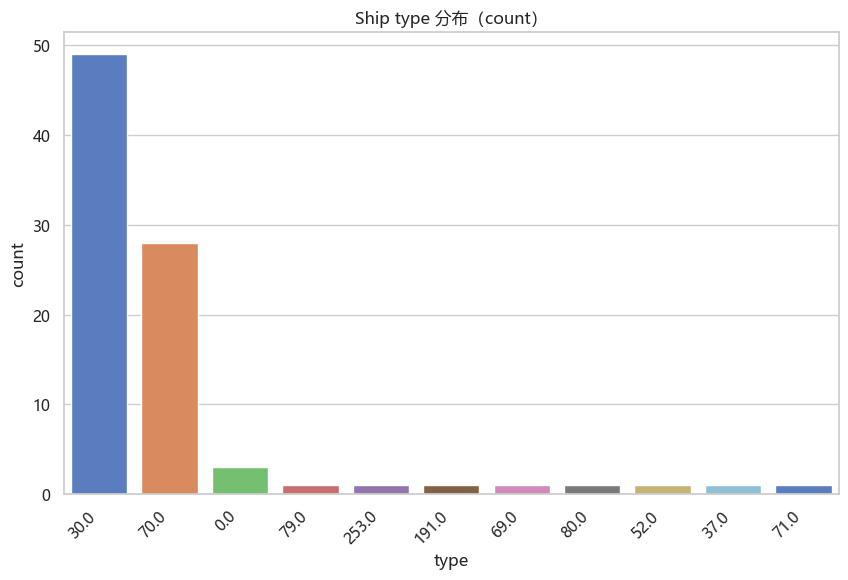

In [12]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=ship_df, x='type', order=ship_df['type'].value_counts().index, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title("Ship type 分布（count）")


In [15]:
ship_types = {
    "货船": [70,71,72,73,74,75,76,77,78,79],
    "油船": [80,81,82,83,84,85,86,87,88,89],
    "客船": [60,61,62,63,64,65,66,67,68,69],
    "渔船": [30],
    "危险品船": [71,72,73,74,81,82,83,84,91,92,93,94],
}
priority = ['危险品船', '货船', '油船', '客船', '渔船']
def classify_overlap(code):
    if pd.isna(code):
        return []  # 或返回 ["未知"]
    try:
        c = int(code)
    except Exception:
        return []
    for label in priority:
        if c in ship_types [label]:
            return label
    return '非运输船'
ship_df["ship_type_list"] = ship_df["type"].apply(classify_overlap)

C:\Users\85842\AppData\Local\Temp\ipykernel_21248\130076717.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=type_series_plot, order=order, palette='muted')


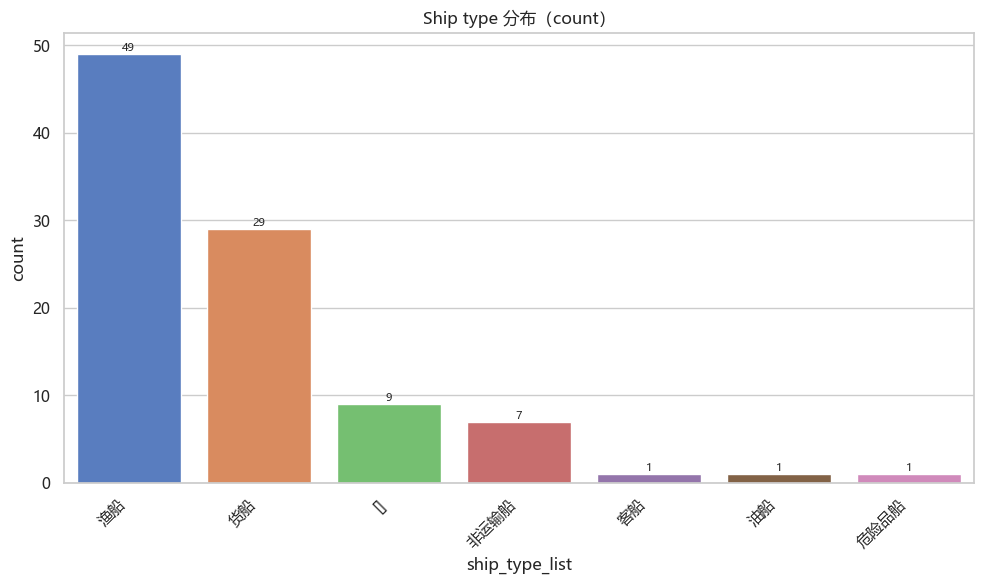

In [16]:
plt.figure(figsize=(10,6))
# NaN
type_series_plot = ship_df['ship_type_list'].fillna('Nan').astype(str)
order = type_series_plot.value_counts().index
ax = sns.countplot(x=type_series_plot, order=order, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title("Ship type 分布（count）")
# 标签
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f"{height:,}", (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()

C:\Users\85842\AppData\Local\Temp\ipykernel_21248\3253479621.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=type_series_plot, order=order, palette='muted')


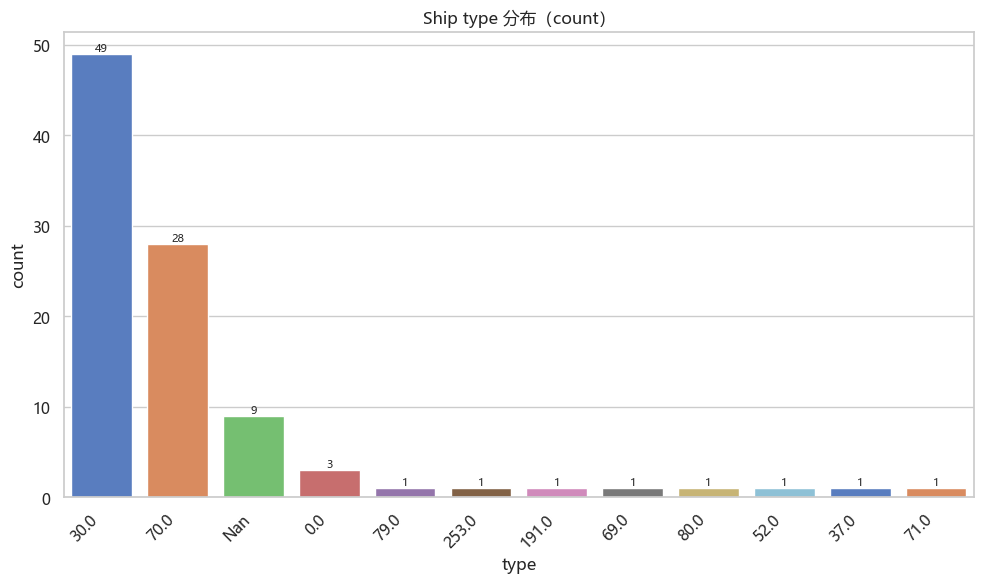

In [13]:
plt.figure(figsize=(10,6))
# NaN
type_series_plot = ship_df['type'].fillna('Nan').astype(str)
order = type_series_plot.value_counts().index
ax = sns.countplot(x=type_series_plot, order=order, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title("Ship type 分布（count）")
# 标签
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f"{height:,}", (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()

In [17]:
ship_df.to_csv(r'C:\Users\85842\OneDrive\文档\GitHub\shandong_AIS\list\船舶表.csv')

In [2]:
import pandas as pd
import numpy as np

In [3]:
ship_list=pd.read_csv(r'C:\Users\85842\OneDrive\文档\GitHub\shandong_AIS\list\2024010112.gz')

In [4]:
ship_list_sorted=ship_list.sort_values('mmsi').reset_index(drop=True)

In [30]:
ship_list_sorted.to_csv(r'C:\Users\85842\OneDrive\文档\GitHub\shandong_AIS\list\ship_list.csv',index=False)

In [6]:
ship_list_sorted=ship_list_sorted.replace(['',0.0],np.nan)
def auto_combine(dataframe):
    group_sorted=dataframe.sort_values(
        by=dataframe.columns.tolist(),
        key=lambda x:x.isna(),
        kind= 'stable')
    result=group_sorted.iloc[0].copy()

    for _,row in group_sorted.iterrows():
        result=result.combine_first(row)
    return result
result_df=ship_list_sorted.groupby('mmsi').apply(auto_combine).reset_index(drop=True)

C:\Users\85842\AppData\Local\Temp\ipykernel_46780\1795960750.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df=ship_list_sorted.groupby('mmsi').apply(auto_combine).reset_index(drop=True)


In [7]:
result_df.to_csv(r'C:\Users\85842\OneDrive\文档\GitHub\shandong_AIS\list\unique_ship_list.csv',index=False)

In [14]:
df=pd.read_csv(r'C:\Users\85842\OneDrive\文档\GitHub\shandong_AIS\list\bhw_points_2024010112.csv')

In [9]:
df = df.merge(result_df[['mmsi','type','length']], on='mmsi', how='left', suffixes=('','_matched'))

In [13]:
df.to_csv(r'C:\Users\85842\OneDrive\文档\GitHub\shandong_AIS\list\unique_bhw_points_2024010112_merged.csv',index=False)

type 编码分布（含缺失）：
type_label  count
   missing    384
      30.0   4218
      37.0     28
      52.0    660
      69.0    189
      70.0   6972
      71.0     29
      79.0    286
      80.0     17
     191.0     15
     253.0    149


C:\Users\85842\AppData\Local\Temp\ipykernel_46780\1468348237.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=type_counts, x="type_label", y="count", palette="viridis")


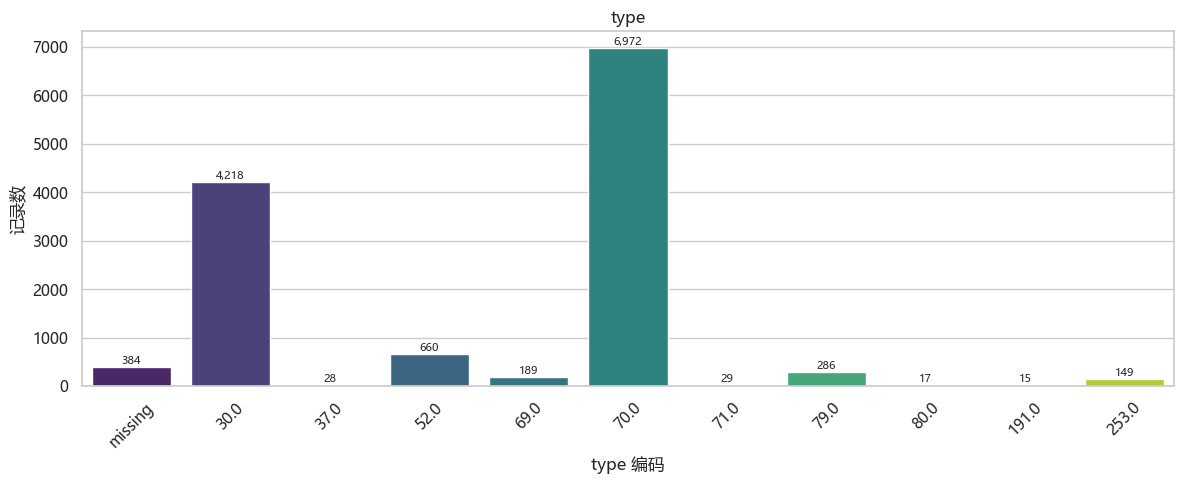

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
type_series = df['type'].astype('Int64')

type_counts = (
    type_series
    .value_counts(dropna=False)
    .rename_axis("type_code")
    .reset_index(name="count")
)

type_counts["type_label"] = type_counts["type_code"].apply(
    lambda code: "missing" if pd.isna(code) else str(code)
)
type_counts["sort_key"] = type_counts["type_code"].fillna(-1)
type_counts = type_counts.sort_values("sort_key").drop(columns="sort_key").reset_index(drop=True)

print("type 编码分布（含缺失）：")
print(type_counts[["type_label", "count"]].to_string(index=False))

sns.set_theme(style="whitegrid")
# 强制设置中文字体，避免图标题/标签乱码
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize=(12, 5))
sns.barplot(data=type_counts, x="type_label", y="count", palette="viridis")
plt.xlabel("type 编码")
plt.ylabel("记录数")
plt.title("type")
plt.xticks(rotation=45)

for tick_idx, count in enumerate(type_counts["count"]):
    plt.text(tick_idx, count, f"{int(count):,}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()

船舶分类计数（仅保留任务关注类型，其余归为“非运输船”）：
ship_category  count
         危险品船     29
           货船   7258
           油船     17
           客船    189
           渔船   4218
         非运输船    852
           未知    384


C:\Users\85842\AppData\Local\Temp\ipykernel_46780\191969929.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


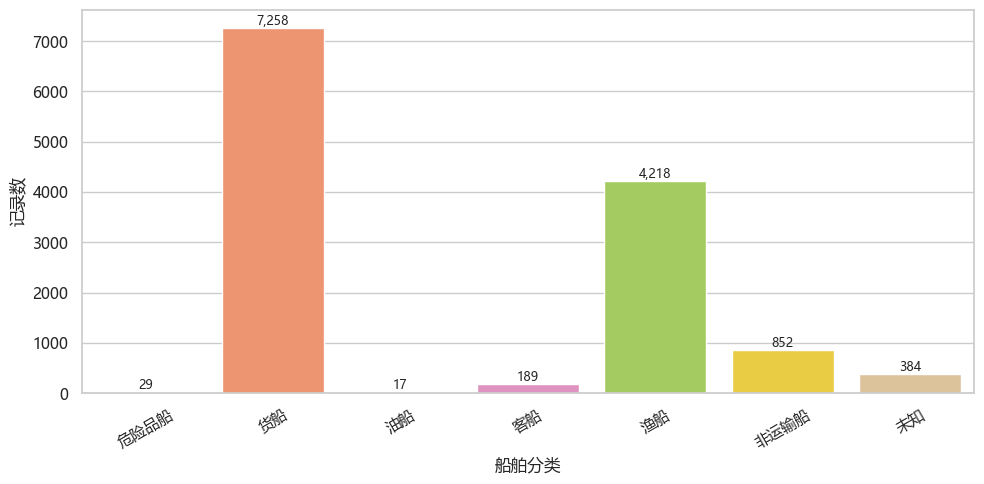

In [12]:
# 强制设置中文字体，避免图标题/标签乱码
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False

danger_codes = {71, 72, 73, 74, 81, 82, 83, 84, 91, 92, 93, 94}
cargo_codes = set(range(70, 80))
oil_codes = set(range(80, 90))
passenger_codes = set(range(60, 70))
fish_codes = {30}

ship_category_rules = [
    ("危险品船", danger_codes),
    ("货船", cargo_codes),
    ("油船", oil_codes),
    ("客船", passenger_codes),
    ("渔船", fish_codes),
]

def classify_ship_type(code):
    if pd.isna(code):
        return "未知"
    code_int = int(code)
    for label, allowed_codes in ship_category_rules:
        if code_int in allowed_codes:
            return label
    return "非运输船"

type_series = df["type"].astype("Int64")
df["ship_category"] = type_series.apply(classify_ship_type)

ship_category_order = [
    "危险品船",
    "货船",
    "油船",
    "客船",
    "渔船",
    "非运输船",
    "未知",
]
category_counts = (
    df["ship_category"]
    .value_counts()
    .reindex(ship_category_order, fill_value=0)
    .rename_axis("ship_category")
    .reset_index(name="count")
)

print("船舶分类计数（仅保留任务关注类型，其余归为“非运输船”）：")
print(category_counts.to_string(index=False))

plt.figure(figsize=(10, 5))
order = category_counts["ship_category"]
sns.barplot(
    data=category_counts,
    x="ship_category",
    y="count",
    palette="Set2",
    order=order,
    saturation=0.8,
    dodge=False,
    )
plt.xlabel("船舶分类")
plt.ylabel("记录数")

plt.xticks(rotation=30)

for idx, row in category_counts.iterrows():
    plt.text(idx, row["count"], f"{int(row['count']):,}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()

In [18]:
df=pd.read_csv(r'C:\Users\85842\OneDrive\文档\GitHub\shandong_AIS\list\unique_bhw_points_2024010112_merged.csv')
df.head()
df['time']=pd.to_datetime(df['time'])

In [19]:

df_sorted = df.sort_values(by=['mmsi', 'time'], ascending=[True, True]).reset_index(drop=True)

In [21]:
df_sorted.drop_duplicates(keep='first', inplace=True)

In [22]:
df_sorted.to_csv(r'C:\Users\85842\OneDrive\文档\GitHub\shandong_AIS\list\unique_bhw_points_2024010112_merged.csv', index=False)